In [1]:
import numpy as np
import pandas as pd
from scipy.special import boxcox, inv_boxcox
from scipy.stats import boxcox_normmax
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import MAE, DistributionLoss
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df_up = pd.read_csv("../data/5_yr_data/UP5_years.csv")
df_up['datetime'] = pd.to_datetime(df_up['date'])
df_up.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
df_up.sort_values(by="datetime", ascending=True, inplace=True)
df_up.head()

,district_name,market_name,commodity,variety,grade,min_rs_quintal,max_rs_quintal,modal_rs_quintal,date,year,month,day_of_month,datetime
714742,Bijnor,Bijnaur,Onion,Red,FAQ,2950.0,3040.0,3000.0,01 Jan 2018,2018,Jan,1,2018-01-01
433767,Mau(Maunathbhanjan),Kopaganj,Wheat,Dara,FAQ,1525.0,1625.0,1575.0,01 Jan 2018,2018,Jan,1,2018-01-01
439485,Gorakhpur,Gorakhpur,Wheat,Dara,FAQ,1560.0,1590.0,1575.0,01 Jan 2018,2018,Jan,1,2018-01-01
83163,Shahjahanpur,Tilhar,Potato,Potato,FAQ,490.0,510.0,500.0,01 Jan 2018,2018,Jan,1,2018-01-01
730321,Bulandshahar,Divai,Onion,Red,FAQ,2800.0,3000.0,2900.0,01 Jan 2018,2018,Jan,1,2018-01-01


In [3]:
TRAIN_LEN = int(0.8 * len(df_up))
up_train, up_test = (df_up[:TRAIN_LEN],df_up[TRAIN_LEN:])
up_train.set_index('datetime', inplace=True)
up_train.sort_index(inplace=True)
up_test.set_index('datetime', inplace=True)
up_test.sort_index(inplace=True)

In [121]:
commodity = "Rice"
df_train_commodity = up_train[up_train['commodity'] == commodity]
df_train_commodity_dt = df_train_commodity.groupby("datetime").agg({"modal_rs_quintal":"mean"})
df_train_commodity_dt

,modal_rs_quintal
datetime,
2018-01-01,2244.840426
2018-01-02,2261.681818
2018-01-03,2235.193548
2018-01-04,2258.073684
2018-01-05,2291.752941
...,...
2023-04-29,2648.738739
2023-04-30,2665.293103
2023-05-01,2614.902913


In [122]:
df_test_commodity = up_test[up_test['commodity'] == commodity]
df_test_commodity_dt = df_test_commodity.groupby("datetime").agg({"modal_rs_quintal":"mean"})
df_test_commodity_dt.head()

,modal_rs_quintal
datetime,
2023-05-03,2581.857143
2023-05-04,2681.118421
2023-05-05,2662.755102
2023-05-06,2594.227273
2023-05-07,2559.982456


In [123]:
df_train_commodity_dt.reset_index(inplace=True)
df_train_commodity_dt['unique_id'] = commodity
df_train_commodity_dt.rename(columns={"datetime" : "ds", "modal_rs_quintal" : "y"}, inplace=True)
df_train_commodity_dt.head()

,ds,y,unique_id
0,2018-01-01,2244.840426,Rice
1,2018-01-02,2261.681818,Rice
2,2018-01-03,2235.193548,Rice
3,2018-01-04,2258.073684,Rice
4,2018-01-05,2291.752941,Rice


In [124]:
df_test_commodity_dt.reset_index(inplace=True)
df_test_commodity_dt['unique_id'] = commodity
df_test_commodity_dt.rename(columns={"datetime" : "ds", "modal_rs_quintal" : "y"}, inplace=True)
df_test_commodity_dt.head()

,ds,y,unique_id
0,2023-05-03,2581.857143,Rice
1,2023-05-04,2681.118421,Rice
2,2023-05-05,2662.755102,Rice
3,2023-05-06,2594.227273,Rice
4,2023-05-07,2559.982456,Rice


In [125]:
df_train_commodity_dt.shape

(1949, 3)

In [126]:
df_test_commodity_dt.shape

(488, 3)

In [127]:
model = NBEATS(h=368, input_size=120,
               loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
               stack_types = ['identity', 'trend', 'seasonality'],
               max_steps=120,
               val_check_steps=16,
               early_stop_patience_steps=4)

fcst = NeuralForecast(
    models=[model],
    freq='D'
)
# fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
fcst.fit(df=df_train_commodity_dt, val_size=488)
forecasts = fcst.predict(futr_df=df_test_commodity_dt)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | blocks       | ModuleList       | 3.9 M  | train
----------------------------------------------------------
3.6 M     Trainable params
359 K     Non-trainable params
3.9 M     Total params
15.664    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=120` reached.
/home/mukundan/learning/ai_ml/sih_2024_project/sih_2024/sihvenv/lib/python3.12/site-packages/neuralforecast/core.py:902: UserWarning: Dropped 120 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/mukundan/learning/ai_ml/sih_2024_project/sih_2024/sihvenv/lib/python3.12/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [128]:
len(forecasts)

368

,ds,y,unique_id,NBEATS,NBEATS-median,NBEATS-lo-90,NBEATS-lo-80,NBEATS-hi-80,NBEATS-hi-90
0,2023-05-03,2581.857143,Rice,2595.201904,2594.5,2513.000000,2529.000000,2658.000000,2678.000000
1,2023-05-04,2681.118421,Rice,2594.333984,2593.0,2517.000000,2531.000000,2656.000000,2674.050049
2,2023-05-05,2662.755102,Rice,2592.501953,2594.0,2509.000000,2525.000000,2654.000000,2671.100098
3,2023-05-06,2594.227273,Rice,2593.382080,2593.0,2513.000000,2530.000000,2656.100098,2678.000000
4,2023-05-07,2559.982456,Rice,2591.391113,2591.0,2510.949951,2526.899902,2656.000000,2677.000000
...,...,...,...,...,...,...,...,...,...
483,2024-08-28,3119.150442,Rice,NaN,NaN,NaN,NaN,NaN,NaN
484,2024-08-29,3136.592233,Rice,NaN,NaN,NaN,NaN,NaN,NaN
485,2024-08-30,3144.841667,Rice,NaN,NaN,NaN,NaN,NaN,NaN
486,2024-08-31,3146.494845,Rice,NaN,NaN,NaN,NaN,NaN,NaN


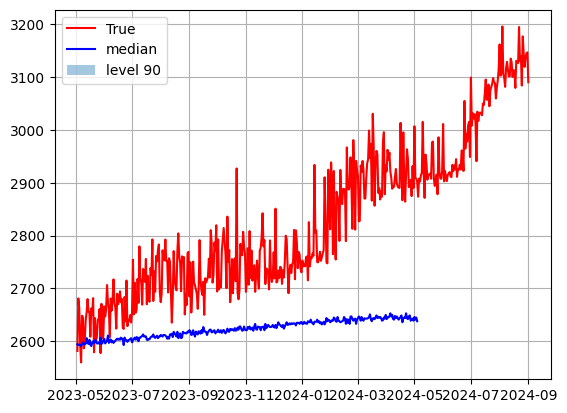

In [129]:
# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])

plot_df = pd.concat([df_test_commodity_dt, Y_hat_df], axis=1)
# plot_df = pd.concat([df_train_commodity_dt, plot_df])

# plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='red', label='True')
plt.plot(plot_df['ds'], plot_df['NBEATS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['NBEATS-lo-90'][-12:].values, 
                 y2=plot_df['NBEATS-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.grid()
plt.legend()
plt.plot()

plot_df

In [130]:
df_test_commodity_dt[:368]

,ds,y,unique_id
0,2023-05-03,2581.857143,Rice
1,2023-05-04,2681.118421,Rice
2,2023-05-05,2662.755102,Rice
3,2023-05-06,2594.227273,Rice
4,2023-05-07,2559.982456,Rice
...,...,...,...
363,2024-04-30,2890.010638,Rice
364,2024-05-01,3006.720000,Rice
365,2024-05-02,2909.326923,Rice
366,2024-05-03,2907.605505,Rice


In [131]:
mae = mean_absolute_error(df_test_commodity_dt[:368]['y'], Y_hat_df['NBEATS-median'])
rmse = np.sqrt(mean_squared_error(df_test_commodity_dt[:368]['y'], Y_hat_df['NBEATS-median']))

In [132]:
print(mae,rmse)

145.87492470580403 169.35277374867988


In [26]:
Y_hat_df.head()

,NBEATS,NBEATS-median,NBEATS-lo-90,NBEATS-lo-80,NBEATS-hi-80,NBEATS-hi-90
0,1128.265015,1128.0,1072.000000,1084.0,1172.099976,1184.050049
1,1123.104004,1123.0,1067.000000,1079.0,1168.000000,1180.000000
2,1125.390015,1124.5,1072.000000,1083.0,1167.000000,1183.000000
3,1126.553955,1126.0,1072.000000,1083.0,1171.000000,1182.000000
4,1127.218994,1127.0,1070.949951,1084.0,1170.000000,1183.000000


In [33]:
df_train_commodity_dt.head()

,ds,y,unique_id
0,2018-01-01,2747.222222,Onion
1,2018-01-02,2757.333333,Onion
2,2018-01-03,2722.439394,Onion
3,2018-01-04,2798.666667,Onion
4,2018-01-05,2753.147541,Onion


In [34]:
df_test_commodity_dt.head()

,ds,y,unique_id
0,2023-05-03,1128.114754,Onion
1,2023-05-04,1117.956522,Onion
2,2023-05-05,1124.852113,Onion
3,2023-05-06,1105.476821,Onion
4,2023-05-07,1106.873786,Onion


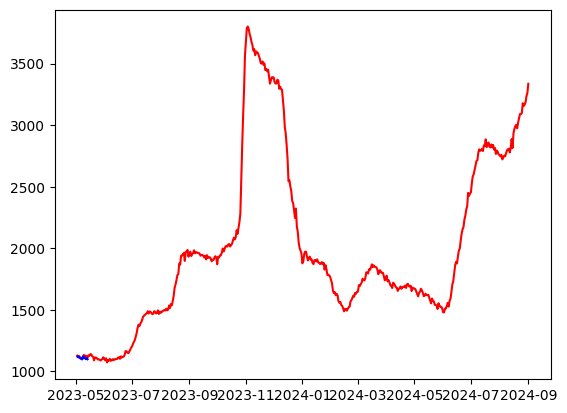

In [39]:
plot_df = pd.concat([df_test_commodity_dt, Y_hat_df], axis=1)
plt.plot(plot_df['ds'], plot_df['y'],  c='red', label='True')
plt.plot(plot_df['ds'], plot_df['NBEATS-median'], c='blue', label='median')

In [ ]:
plot_df = pd.concat([df_train_commodity_dt, plot_df])
plot_df

In [ ]:
use_boxcox = False  # Set to False if not using Box-Cox

# commodities = df_up['commodity'].unique()

# for commodity in commodities:
    # Train-test split
    train_len = int(len(boxcox_diff_dfs[commodity]) * 0.8)
    df_train = boxcox_diff_dfs[commodity][:train_len - 1]

    df_test_commodity = up_test[up_test['commodity'] == commodity]
    df_test_commodity_dt = df_test_commodity.groupby("datetime").agg({"modal_rs_quintal": "mean"})

    if use_boxcox:
        # Box-Cox transformation
        lmbda = boxcox_normmax(df_train)  # Optimize lambda for Box-Cox
        df_test_commodity_boxcox = pd.Series(boxcox(df_test_commodity_dt['modal_rs_quintal'], lmbda=lmbda),
                                             index=df_test_commodity_dt.index)
        df_test = pd.Series(df_test_commodity_boxcox - df_test_commodity_boxcox.shift(), index=df_test_commodity_boxcox.index)
        df_test.dropna(inplace=True)
    else:
        # df_test_commodity_dt.set_index("datetime")
        df_test = df_test_commodity_dt['modal_rs_quintal']

    # Prepare training data
    df_train = df_train.to_frame(name='y')
    df_train['unique_id'] = commodity
    df_train['ds'] = df_train.index

    # Prepare test data for predictions
    df_test_pred = df_test.to_frame(name='y')
    df_test_pred['unique_id'] = commodity
    df_test_pred['ds'] = df_test_pred.index
    input_size = 120  # Use past 14 days to forecast
    horizon = 120    # Forecasting the next 14 days

    # Initialize N-BEATS model
    nbeats_model = NBEATS(
    input_size=input_size,
    h=horizon,
    n_blocks=[2, 2],  # Two blocks each for trend and seasonality
    stack_types=['trend', 'seasonality'],  # Trend and seasonality stacks
    mlp_units=1*[[128, 128]],  # Hidden units for MLP layers in the blocks
    loss=MAE(),  # Mean Absolute Error
    )

    # Initialize NeuralForecast object
    fcst = NeuralForecast(models=[nbeats_model], freq='D')

    # Train the model on the training data
    fcst.fit(df_train)
    forecast = fcst.predict(df_test_pred)

# Prepare actual values and predicted values
    y_hat = df_test.copy()
    y_hat['nbeats_forecast'] = forecast['NBEATS'].values

    # If using Box-Cox, invert the transformation
    if use_boxcox:
        y_hat['nbeats_forecast'] = inv_boxcox(y_hat['nbeats_forecast'].cumsum(), lmbda)
    else:
        y_hat['nbeats_forecast'] = y_hat['nbeats_forecast'].cumsum()

    

In [ ]:
# Plot the results
def plot_results(up_train ,commodity):
    up_train_commodity = up_train[up_train['commodity'] == commodity]
    up_train_commodity_dt = up_train_commodity.groupby("datetime").agg({"modal_rs_quintal": "mean"})
    up_test_commodity_dt = up_test[up_test['commodity'] == commodity].groupby("datetime").agg({"modal_rs_quintal": "mean"})

    plt.plot(up_train_commodity_dt, label="Train")
    plt.plot(up_test_commodity_dt, label="Test")
    plt.plot(y_hat['nbeats_forecast'], label="N-BEATS forecast")
    plt.legend(loc="best")
    plt.show()
    mae = mean_absolute_error(df_test[:horizon], y_hat['nbeats_forecast'])
    rmse = np.sqrt(mean_squared_error(df_test[:horizon], y_hat['nbeats_forecast']))
    print(y_hat.index,y_hat['nbeats_forecast'])

    print(f'N-BEATS Mean Absolute Error (MAE): {mae:.4f}')
    print(f'N-BEATS Root Mean Squared Error (RMSE): {rmse:.4f}')